# ***Recurrent Neural Networks (RNNs)***

## ***Part 1: Understanding Sequential Data with the d2l Library***

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l # pip install d2l

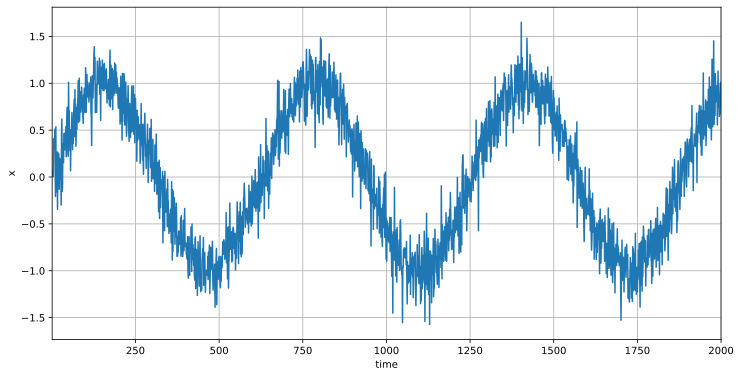

In [ ]:
# These following examples showcase sequential data modelling use simple linear regression.

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=2000, num_train=600, tau=3):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 2000], figsize=(12, 6))

In [27]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

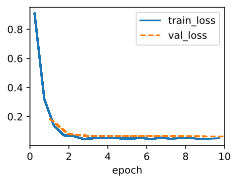

In [ ]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)  m

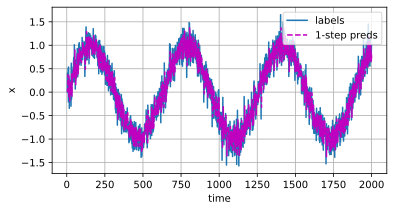

In [30]:
# one step ahead prediction

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

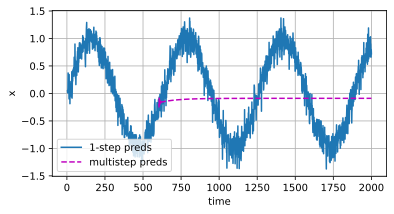

In [31]:
# Multiple steps ahead into the future: Epic fail edition:

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

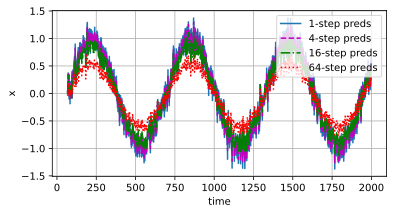

In [32]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))



### Book Exercises

Improve the model in the experiment of this section.

Incorporate more than the past four observations? How many do you really need?

How many past observations would you need if there was no noise? 

An investor wants to find a good security to buy. They look at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?

Does causality also apply to text? To which extent?

Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.